In [1]:

# Ejemplo de clasificacion multiclass: 
# clasificacion de imagenes de ropa.

# dataset con 60,000 imagenes de training de 28x28 en escada de grises de 10 categorias de ropa. Otros
# 10,000 imagenes para test.

# Las clases son:

#0	T-shirt/top
#1	Trouser
#2	Pullover
#3	Dress
#4	Coat
#5	Sandal
#6	Shirt
#7	Sneaker
#8	Bag
#9	Ankle boot

# La idea es entrenar una NN convolucional para hacer un clasificador multiclass de las10 clases
# La NN tendra una capa escondida convolucional con un kernel de 3x3 con 32 canales (o filtros)
# para capturar los distintos features de las imagenes.
# Luego, una capa flatten que hace de entrada a la capa escondida densa tradicional para efectos de 
# clasificacion.


In [23]:

# carga de paquetes

import tensorflow as tf

import matplotlib.pyplot as plt

layers = tf.keras.layers

import numpy as np
print('Tensorflow Version ', tf.__version__)

Tensorflow Version  2.0.0


In [24]:
# descargamos la dataset desde tf 
# https://keras.io/api/datasets/fashion_mnist/


mnist = tf.keras.datasets.fashion_mnist
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
(trainX, trainY), (testX, testY) = mnist.load_data()

print(trainX.shape)   # 60,000 arrays de 28x28
print(trainY.shape) 

(60000, 28, 28)
(60000,)


In [25]:
# Como son imagenes B&W, las imagenes solo tienen 1 canal.

# # reshape dataset  para tener un canal unico 
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

print(trainX.shape)  #  60,000 imagenes de 28x28 con 1 canal

#print(testY)  #[9 2 1 ... 8 1 5]
#print(trainY) # [9, 0, 0, ..., 3, 0, 5]

(60000, 28, 28, 1)


In [26]:
# vamos a simplificar las imagenes, binarizando las imagenes en blanco-negro utilizando enconding.

# recordemos que OneHotEncoder  codifica variables categoricas de N niveles utilizando N bits. 
# si N=3,  100, 010, 001.
# el LabelEncoder codifica target de N clases con valores de 0 a N-1.

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# integer encode  (para el target)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(trainY)
print(integer_encoded)  # 
print(integer_encoded.shape) # (60000,)

[9 0 0 ... 3 0 5]
(60000,)


In [27]:
# binary encode
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1) # transforma a arrat 60,000 x 1
#print(integer_encoded)  # 
print(integer_encoded.shape) # (60000, 1)


(60000, 1)


In [28]:
# y ahora usamo onehotencoder para formar vectores de largo 10 que nos indican la clase a la que corresponde
# cada instancia
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
trainY = integer_encoded


[[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [29]:
# hacemos lo mismo para testY

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(testY)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
testY = integer_encoded

# one hot encode target values
#trainY = to_categorical(trainY)
#testY = to_categorical(testY)
    

[9 2 1 ... 8 1 5]
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [30]:
# vamos a escalar los pixeles unsando la  siguiente funcion
# esto es muy importante. Si no lo hace, el desempeno del clasificador es muy pobre.

# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm


trainX_norm, testX_norm = prep_pixels(trainX, testX)

print(trainX_norm.shape)
print(testX_norm.shape)  

trainX = trainX_norm
testX = testX_norm

(60000, 28, 28, 1)
(10000, 28, 28, 1)


TypeError: Invalid shape (28, 28, 1) for image data

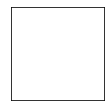

In [31]:
# Para tener una idea de los datos, vamos a plotear algunas instancias.

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(25):
 plt.subplot(5,5,i+1)
 plt.xticks([])
 plt.yticks([])
 plt.grid(False)
 plt.imshow(trainX[i], cmap=plt.cm.binary)
 #plt.xlabel(class_names[trainY[i]])
plt.show()

In [32]:
# ahora viene el diseño de la red:

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD


# tenemos una capa convolucional (feature extraction) seguida de una capa de agregacion, y finalmente un clasificador
# que hace la prediccion.

# Para la capa convolucional, podemos utilizar un kernel pequeño de 3X3 con un número de modesto de 32 canales.
# Luego seguido de la capa de agregacion. Luego la capa Flatten lo unico que hace es convertir
# el mapeo de la capa de agregacion en un vector (reducto de dimensionalidad), que entra como input
# al clasificador. 

model = Sequential()
#model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1), 
#                kernel_regularizer =tf.keras.regularizers.l1( l=0.01)) )
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1) ))
model.add(Dropout(0.2))

          
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))

# compila
opt = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [34]:
# Training
# nota: yo apenas le puse epoch=1, pero Ud hagalo con mas.

history = model.fit(trainX, trainY, epochs=5, batch_size=32, validation_data=(testX, testY), verbose=1)
#history = model.fit(trainX, trainY, epochs=5, batch_size=32, validation_split=0.15, verbose=1)
#history = model.fit(trainX, trainY, epochs=5, batch_size=32, validation_split=0.15, verbose=1, batch_size=64)



Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 245s 4ms/sample - loss: 0.4124 - accuracy: 0.8517 - val_loss: 0.3414 - val_accuracy: 0.8767
Epoch 2/5
 8256/60000 [===>..........................] - ETA: 3:04 - loss: 0.2963 - accuracy: 0.8957

KeyboardInterrupt: 

In [14]:
# evaluar el modelo
_, acc = model.evaluate(testX, testY, verbose=0)
print('> %.3f' % (acc * 100.0))

> 85.540


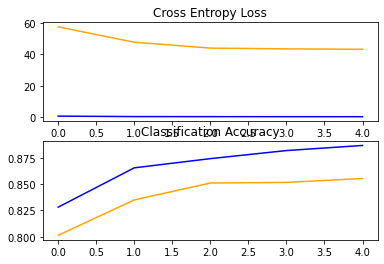

In [17]:
from matplotlib import pyplot

# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')

# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')

pyplot.show()


In [46]:
history.history

{'loss': [0.285524899900953,
  0.24385585407515367,
  0.21641914153397082,
  0.1930176695595185,
  0.17308147877802452],
 'acc': [0.8971, 0.91055, 0.92006665, 0.92865, 0.9360333],
 'val_loss': [2.4373193715315646,
  2.229857486128801,
  1.8696737136760588,
  2.1993166664123533,
  1.9022067698955478],
 'val_acc': [0.8459, 0.8593, 0.882, 0.8617, 0.8797]}

In [47]:
history.history['loss']

[0.285524899900953,
 0.24385585407515367,
 0.21641914153397082,
 0.1930176695595185,
 0.17308147877802452]